# Overview

This week we'll talk about advanced network measures (beyond the degree distribution). We will use these tools to make sense of the network of the Country Musicians on Wikipedia. 
This is the outline for today:

* Visualization and qualitative analysis of the Country Music Artists Network
* Properties of the network structure
* Finally some more visualizations

> _Reading_: This week, the reading is mostly for reference. It's for you to have a place to go, if you want more detailed information about the topics that I cover in the video lectures. Thus, I recommend you check out **Chapter 9** of the network science book. In particular, we'll delve into [Section 9.4](http://networksciencebook.com/chapter/9#modularity) in the exercises below. We will also talk a little bit about degree correlations - you can read about those in [Chapter 7](http://networksciencebook.com/chapter/7)\.

# Part A: Let's  visualise some more!

Visualization is a big part of network science and (while powerful), the tools built into `NetworkX` are not the most powerful. Therefore, we'll explore another layout in the exercise below. 

Specifically, we will use the [`ForceAtlas2`](https://journals.plos.org/plosone/article%3Fid=10.1371/journal.pone.0098679) package produces som nice layouts. ForceAtlas2 was developed by the creators of the [Gephy graph analysis software](https://gephi.org).

Unfortunately, the canonical version of ForceAtlas on GitHub ([Force Atlas 2 algorithm](https://github.com/bhargavchippada/forceatlas2)) isn't being maintained, so we'll use this fork that's continually updating the original source: https://github.com/AminAlam/fa2_modified below.

**Note**: Finally, I have to say that the Country Music Network is very much a hairball of interconnections, so not even ForceAtlas2 can extract much structure from it. ***But don't worry ... ForceAtlas2 is still worth your time and we'll untangle the hairball in subsequent exercises***.

*Exercise 1:* Plot the Network using ForceAtlas2. For visualization, you should work with the network from last time, the Giant Connected Component ... and the undirected version.

>1. The [Force Atlas 2 algorithm](https://github.com/AminAlam/fa2_modified) helps calculate more aesthetically pleasing positions for the nodes for your network visualizations.
>2. Follow the instructionf on the GitHub page. That page also how to use the package to get coordinates for each node. You can then feed those coordinates to NetworkX (see below).
> * Visualize the network using the [NetworkX draw function](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw), and node-coordinates from the force atlas algorithm. As in the previous Exercise:
>   * Node color should depend on the `length_of_content` attribute (see notes from last week).
>   * Node size should depend on the node *degree*
> * Play with the force atlas algorithm parameters to obtain a visualization you like. 

<div class="alert alert-block alert-info">
It's OK to use your LLM as much as needed for this exercise. The only goal is to create a nice visualization.
</div>

In [1]:
import os 
import re
import networkx as nx

# Generate the Country Music Network from Assignment 1
output_dir=r'C:\Users\jdiaz\Desktop\DTU_SocialGraphs\country_performers'
raw_performers = [file.replace('_', ' ').replace('.txt', '') for file in os.listdir(output_dir) if file.endswith('.txt')]
raw_performers = [performer.replace(' ', '_') for performer in raw_performers]  



# In the dataset there are some keywords that are not performers, we exclude them
keywords_to_exclude = ["List", "Country_music", "Country_Music_Hall_of_Fame", "List_of_country_music_performers", 
"List_of_country_performers", "List_of_country_music_performers_by_genre",]
performers = [performer for performer in raw_performers if not any(keyword in performer for keyword in keywords_to_exclude)]

              
def count_words(content):
    # Regular expression to find words
    words = re.findall(r'\b\w+\b', content)
    return len(words)

def extract_links(page_content, performers):
    # Regular expression to find links within double square brackets [[...]]
    links = re.findall(r'\[\[([^\]|]+)', page_content)
    # Filter links to keep only those in the performers list
    filtered_links = [link.replace(' ', '_') for link in links if link.replace(' ', '_') in performers]
    return filtered_links


# Create a directed graph
G = nx.DiGraph()

for performer in performers:
    # Read the content of the file
    file_path = os.path.join(output_dir, f"{performer.replace('_', ' ')}.txt")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        page_content = f.read()
        
    # Extract links from the page content
    links = extract_links(page_content, performers)
    
    # Add node with word count as an attribute
    word_count = len(re.findall(r'\b\w+\b', page_content))
    content_length = len(page_content)
    G.add_node(performer, word_count=word_count, content_length=content_length)
    
    # Add edges to the graph, only if the link (performer/person) is in the performers list
    for link in links:
        if link not in G.nodes():
            G.add_node(link)
        G.add_edge(performer, link)

# Remove isolated nodes
isolated_nodes = [node for node in G.nodes() if G.out_degree(node) == 0 and G.in_degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.59it/s]


BarnesHut Approximation  took  5.30  seconds
Repulsion forces  took  32.96  seconds
Gravitational forces  took  0.21  seconds
Attraction forces  took  0.14  seconds
AdjustSpeedAndApplyForces step  took  0.81  seconds


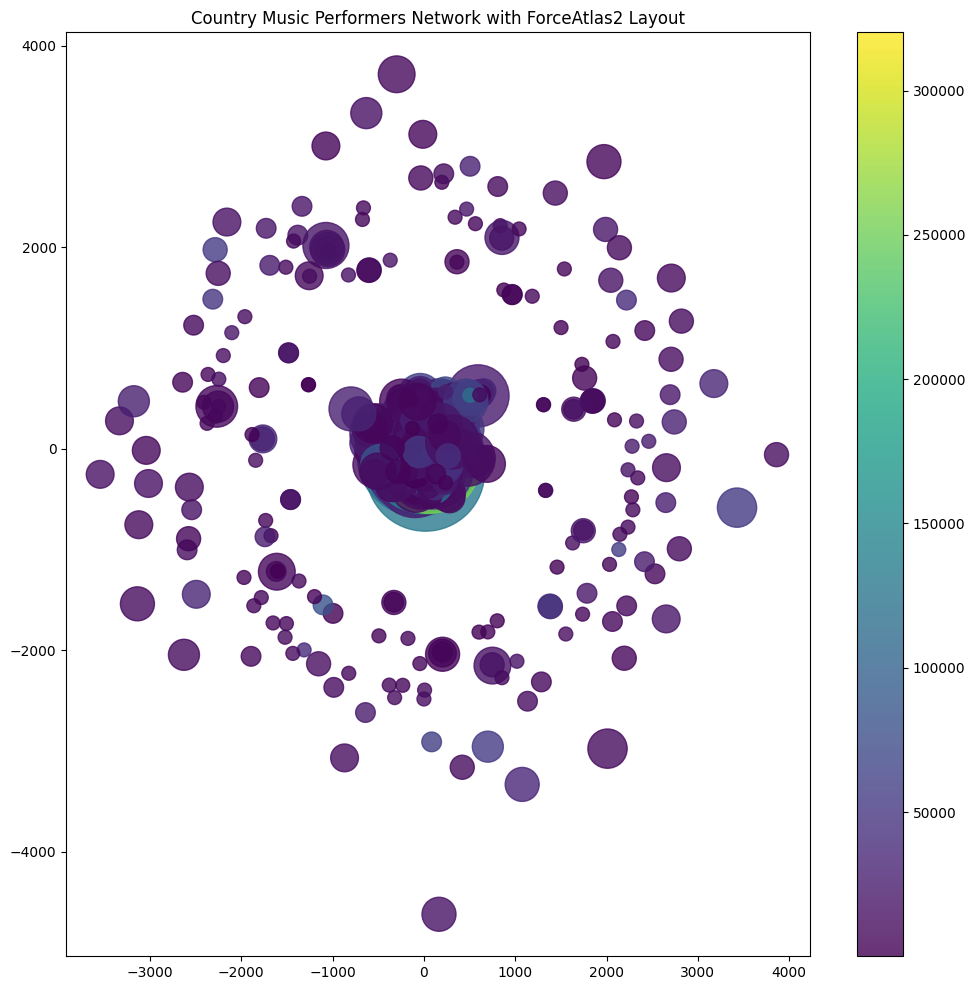

In [2]:
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

# Initialize the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # Traditional repulsion
    adjustSizes=False,  # Don't avoid overlap
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,  # Tolerance for simulation, typically 1.0 is a good value
    barnesHutOptimize=True,  # Use Barnes-Hut approximation for better performance on larger graphs
    barnesHutTheta=1.2,
    multiThreaded=False,  # Multi-threading can speed up computation on larger graphs
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True  # Prints progress
)

# Run ForceAtlas2 to get the positions of the nodes
pos = forceatlas2.forceatlas2_networkx_layout(G, iterations=2000)

# Get node attributes for color and size
length_of_content = np.array([G.nodes[n]['content_length'] for n in G.nodes()])
node_sizes = np.array([G.degree(n) * 100 for n in G.nodes()])  # Scale the node sizes by degree

# Normalize the color map for the 'length_of_content'
norm = mcolors.Normalize(vmin=length_of_content.min(), vmax=length_of_content.max())

# Create the plot
plt.figure(figsize=(12, 12))

# Scatter plot using the node positions from ForceAtlas2
sc = plt.scatter(
    [pos[n][0] for n in G.nodes()],   # X coordinates of nodes
    [pos[n][1] for n in G.nodes()],   # Y coordinates of nodes
    c=length_of_content,              # Node colors based on content length
    s=node_sizes,                     # Node sizes based on degree
    cmap='viridis',                   # Colormap
    norm=norm,                        # Normalized colors
    alpha=0.8                         # Transparency
)

# Add a color bar
plt.colorbar(sc)

# Set title and show the plot
plt.title('Country Music Performers Network with ForceAtlas2 Layout')
plt.show()


*Exercise 2*: We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data manually will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

> 1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
>    * Consider the set of neighbours pointing towards the node found above. 
>    * What is the relation between the characters you identified and their network neighbours? (e.g. did they sing a song togtether)?, are they opponents?, etc ...). You don't need to come up with a grand theory of Country Music here, I just want you to think about how links arise, why the links are there.
>    * Repeat the exercise for the highest out-degree node. 
>    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
> 4. Create a scatter plot, where each node is a point, and the axes show in- versus out-degree. That way you can visually inspect the patterns of how in- and out-degree are connected across all the nodes in the network. Comment on what you see.
> 5. Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
> 6. Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens?

<div class="alert alert-block alert-info">
For this one, I hope you'll limit your LLM use. It's OK to get help in creating the scatter plot, but use NetworkX on your own to identify nodes, and do your own reading and interpreting of Wiki pages.
</div>

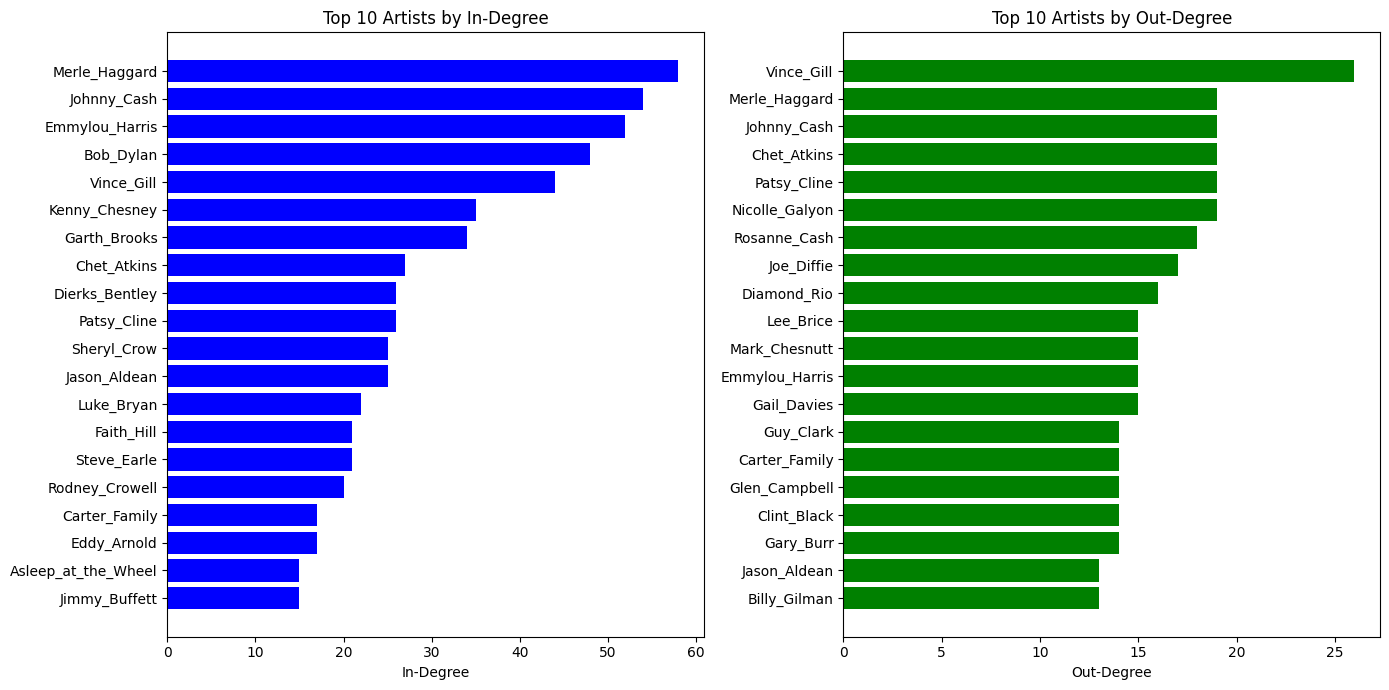

In [3]:
# nodes with the highest in degree represent performers who are referenced the most by other performers
top_10_in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:20]
top_10_in_names, top_10_in_values = zip(*top_10_in_degrees)

# nodes with the highest out degree represent performers who reference many others
top_10_out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:20]
top_10_out_names, top_10_out_values = zip(*top_10_out_degrees)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.barh(top_10_in_names, top_10_in_values, color='blue')
plt.xlabel('In-Degree')
plt.title('Top 10 Artists by In-Degree')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(top_10_out_names, top_10_out_values, color='green')
plt.xlabel('Out-Degree')
plt.title('Top 10 Artists by Out-Degree')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [4]:
print(f"Top 20 in degree {top_10_in_names}")
print("\n")
print(f"Top 20 out degree {top_10_out_names}")

Top 20 in degree ('Merle_Haggard', 'Johnny_Cash', 'Emmylou_Harris', 'Bob_Dylan', 'Vince_Gill', 'Kenny_Chesney', 'Garth_Brooks', 'Chet_Atkins', 'Dierks_Bentley', 'Patsy_Cline', 'Sheryl_Crow', 'Jason_Aldean', 'Luke_Bryan', 'Faith_Hill', 'Steve_Earle', 'Rodney_Crowell', 'Carter_Family', 'Eddy_Arnold', 'Asleep_at_the_Wheel', 'Jimmy_Buffett')


Top 20 out degree ('Vince_Gill', 'Merle_Haggard', 'Johnny_Cash', 'Chet_Atkins', 'Patsy_Cline', 'Nicolle_Galyon', 'Rosanne_Cash', 'Joe_Diffie', 'Diamond_Rio', 'Lee_Brice', 'Mark_Chesnutt', 'Emmylou_Harris', 'Gail_Davies', 'Guy_Clark', 'Carter_Family', 'Glen_Campbell', 'Clint_Black', 'Gary_Burr', 'Jason_Aldean', 'Billy_Gilman')


In [5]:
import networkx as nx

# Assuming you already have your graph 'G'
# Calculate in-degrees and out-degrees
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Create a DataFrame to hold the degrees for easy visualization
import pandas as pd

degrees_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'In-Degree': [in_degrees[node] for node in G.nodes()],
    'Out-Degree': [out_degrees[node] for node in G.nodes()]
})

# Display the degrees DataFrame
print(degrees_df)

# You can also sort by in-degree or out-degree if desired
sorted_in_degrees = degrees_df.sort_values(by='In-Degree', ascending=False)
sorted_out_degrees = degrees_df.sort_values(by='Out-Degree', ascending=False)

print("Top 20 Nodes by In-Degree:")
print(sorted_in_degrees.head(20))

print("\nTop 20 Nodes by Out-Degree:")
print(sorted_out_degrees.head(20))

                              Node  In-Degree  Out-Degree
0               3_of_Hearts_(band)          1           0
1                         4_Runner          3           4
2                      Diamond_Rio          9          16
3                     Amie_Comeaux          1           0
4    Great_Plains_(Tennessee_band)          3           8
..                             ...        ...         ...
646                 Vernon_Dalhart          0           1
647           Veronica_Ballestrini          0           1
648                 Whitney_Duncan          0           2
649         Wilf_Carter_(musician)          0           2
650                  Willy_DeVille          0           1

[651 rows x 3 columns]
Top 20 Nodes by In-Degree:
               Node  In-Degree  Out-Degree
17    Merle_Haggard         58          19
69      Johnny_Cash         54          19
94   Emmylou_Harris         52          15
98        Bob_Dylan         48           7
27       Vince_Gill         44        

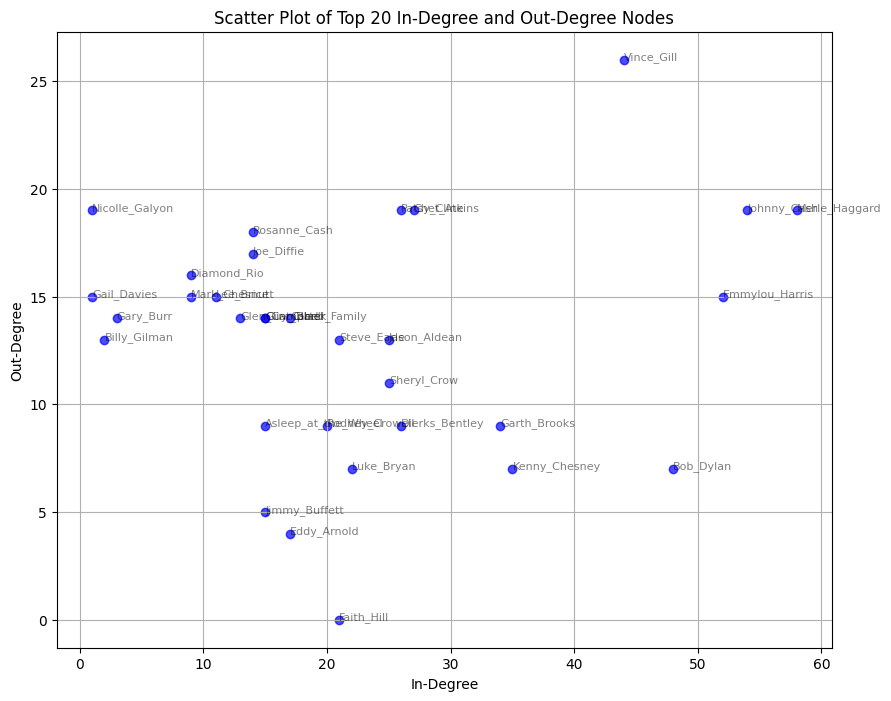

In [14]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have your graph 'G'
# Calculate in-degrees and out-degrees
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Sort nodes by in-degree and out-degree
top_in_degree_nodes = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:20]
top_out_degree_nodes = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:20]

# Create a set to ensure no duplicates between the two groups
top_nodes = set([node for node, _ in top_in_degree_nodes] + [node for node, _ in top_out_degree_nodes])

# Create a DataFrame to hold the degrees for top nodes
degrees_df = pd.DataFrame({
    'Node': list(top_nodes),
    'In-Degree': [in_degrees[node] for node in top_nodes],
    'Out-Degree': [out_degrees[node] for node in top_nodes]
})

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(degrees_df['In-Degree'], degrees_df['Out-Degree'], alpha=0.7, color='blue')

# Set labels and title
plt.xlabel('In-Degree')
plt.ylabel('Out-Degree')
plt.title('Scatter Plot of Top 20 In-Degree and Out-Degree Nodes')
plt.grid(True)

# Add annotations for each point
for i in range(len(degrees_df)):
    plt.annotate(degrees_df['Node'][i], 
                 (degrees_df['In-Degree'][i], degrees_df['Out-Degree'][i]),
                 fontsize=8, alpha=0.5)

# Show the plot
plt.show()

# Part B:  Advanced tools 

> **Video lecture**: *Network measures*. There's an updated video below, and if you can't get enough, you can watch the original version from 2015 [here](https://www.youtube.com/watch?v=0uAYpOqVHCU).

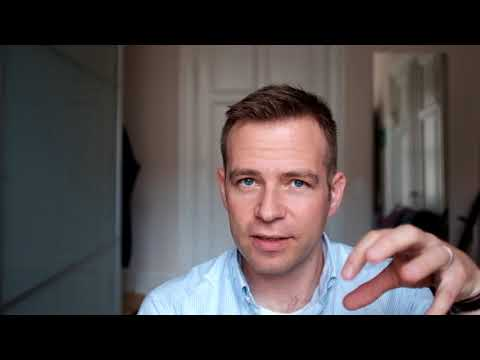

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo("IOWXZFOyk9Y", width=800, height=450)

*Exercise 3:* Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the *directed* graph (rememeber, we asked you to keep one?).

> 1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
> 2. Let's also look at the *[exponent of the degree distribution](http://networksciencebook.com/chapter/4#degree-exponent)* 
>    * To calculate it, you can install [`powerlaw`](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777) package (I could not install in conda, so I used `pip install powerlaw`)
>    * Use `powerlaw.Fit(degree).alpha` for fitting
>    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
>    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
>    * A long time ago, a group of scientists analyzed the network spanned by ***all** of Wikipedia (the paper is called [Wikipedias: Collaborative web-based encyclopedias as complex networks](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.74.016115); to access this paper, use findit.dtu.dk or read the preprint on [arXiv](https://arxiv.org/abs/physics/0602149)). Do your findings correspond to the results described in Chapter **III.A** of that paper? If not, try to give your explanation of why? 
> 3. Plot a heatmap [(Hint here)](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set) of the the in- versus out- degree for all characters. Zoom in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot. What is the advantage of using a heatmap over the scatter plot from the previous Exercise (especially for understanding what's going on in this area)?
> 4. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version? Which questions? Can you think of examples when the in/out distinction doesn't matter.
> 5. We have one more metric that we have used, but not investigated so far. The node-attribute `length_of_content`. There are two things to look at.
>    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it? 
>    * Secondly, and more interestingly, it could be that longer texts means *more famous* characters. And that means more in-links. 
>    * How should you test this? Well, here you are allowed to be **creative**. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using [spearman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html) or [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlations, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words.

<div class="alert alert-block alert-info">
For this exercise, I also hope you'll limit your LLM use. Especially for the intrepretation parts. It's OK to get help for the heatmap in sub-part 3, maybe also for ideas of how to do the testing in part 5. But do your own interpretation :)
</div>

In [8]:
import numpy as np
import pandas as pd
from scipy import stats

# Calculate in-degree and out-degree
in_degrees = np.array([d for n, d in G.in_degree()])
out_degrees = np.array([d for n, d in G.out_degree()])

# Create a DataFrame to summarize the statistics
degree_stats = pd.DataFrame({
    'In-Degree': [
        np.mean(in_degrees),
        np.median(in_degrees),
        stats.mode(in_degrees)[0],  # Extract the mode
        np.min(in_degrees),
        np.max(in_degrees)
    ],
    'Out-Degree': [
        np.mean(out_degrees),
        np.median(out_degrees),
        stats.mode(out_degrees)[0],  # Extract the mode
        np.min(out_degrees),
        np.max(out_degrees)
    ]
}, index=['Mean', 'Median', 'Mode', 'Min', 'Max'])

print(degree_stats)



        In-Degree  Out-Degree
Mean     3.457757    3.457757
Median   1.000000    2.000000
Mode     1.000000    1.000000
Min      0.000000    0.000000
Max     58.000000   26.000000


In [9]:
import powerlaw

# Fit in-degree and out-degree distributions
fit_in = powerlaw.Fit(in_degrees)
fit_out = powerlaw.Fit(out_degrees)

# Get the exponents
alpha_in = fit_in.alpha
alpha_out = fit_out.alpha

print(f"In-Degree Exponent: {alpha_in}")
print(f"Out-Degree Exponent: {alpha_out}")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-Degree Exponent: 2.4479378989244855
Out-Degree Exponent: 4.4484995251349915


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


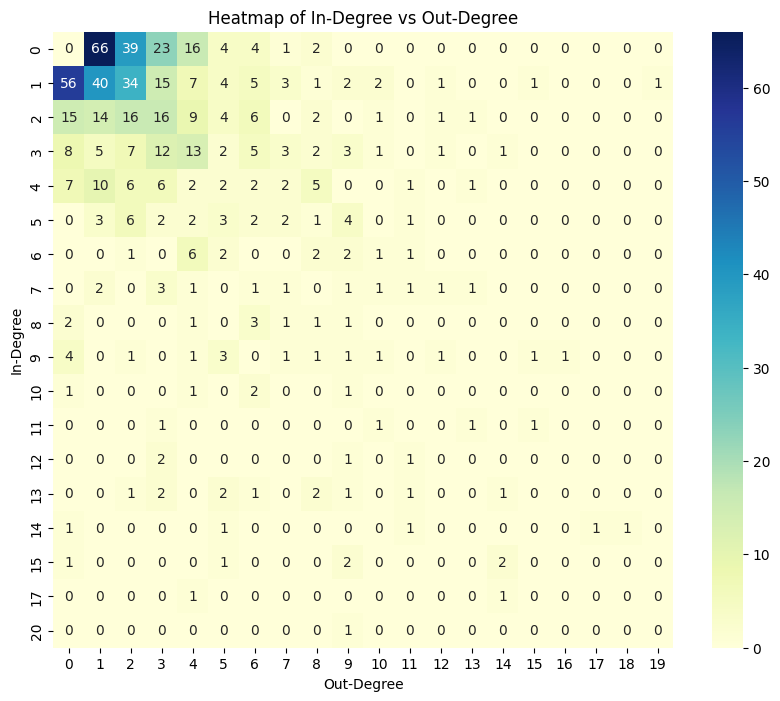

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for heatmap
degree_df = pd.DataFrame({
    'In-Degree': in_degrees,
    'Out-Degree': out_degrees
})

# Create heatmap for in-degree vs out-degree
plt.figure(figsize=(10, 8))
sns.heatmap(degree_df[(degree_df['In-Degree'] <= 20) & (degree_df['Out-Degree'] <= 20)].pivot_table(index='In-Degree', columns='Out-Degree', aggfunc='size', fill_value=0),
            cmap='YlGnBu', annot=True, fmt='d')

plt.title('Heatmap of In-Degree vs Out-Degree')
plt.xlabel('Out-Degree')
plt.ylabel('In-Degree')
plt.show()

In [11]:
# Assuming you have a 'length_of_content' attribute for nodes
length_of_content = np.array([G.nodes[n]['length_of_content'] for n in G.nodes()])

# Correlation between length_of_content and out-degree
correlation = np.corrcoef(length_of_content, out_degrees)[0, 1]
print(f"Correlation between text length and out-degree: {correlation}")

# Visualization
plt.scatter(length_of_content, out_degrees)
plt.xlabel('Length of Content')
plt.ylabel('Out-Degree')
plt.title('Length of Content vs Out-Degree')
plt.show()


KeyError: 'length_of_content'

In [ ]:
# Example of adding the length_of_content attribute to nodes
for n in G.nodes():
    G.nodes[n]['length_of_content'] = len(n)  # or any logic to determine content length


*Exercise 4:* Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality). 

Now let's dig in and try to understand more about the network using more advanced features. 

**Note**: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. 
> 1. Find the 5 most central characters according to degree centrality. 
> 1. Find the 5 most central characters according to betweenness centrality. 
>    * Repeat Exercise 1. However, this time use *betweenness centrality* to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network? 
> 2. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). 
>    * Repeat Exercise 1 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
>    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
> 3. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why? 
>     * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
> 4. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
> 5. Is the undirected version of the graph [assortative](https://en.wikipedia.org/wiki/Assortativity) with respect do the `length_of_content` nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and *vice versa*?.
>      * Hint: Use [this function](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient). Provide an interpretation of your answer.
> 6. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes $N$  and probablity of connection $p$?
>    * Take a look at the *distribution* of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

<div class="alert alert-block alert-info">
As in the two previous exercises, I hope you'll limit your LLM use. Try to get a sense of working with NetworkX. And to grow your brain, do your own intrepretation parts ... it's difficult, but that's how you grow.</div>

1.Find the 5 most central characters according to degree centrality.

In [15]:
# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality and get top 5
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by degree centrality:", top_degree_centrality)


Top 5 nodes by degree centrality: [('Merle_Haggard', 0.11846153846153847), ('Johnny_Cash', 0.1123076923076923), ('Vince_Gill', 0.1076923076923077), ('Emmylou_Harris', 0.10307692307692308), ('Bob_Dylan', 0.08461538461538462)]


2.Find the 5 most central characters according to betweenness centrality.

In [26]:
# Calculate betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(G)

# Sort nodes by betweenness centrality and get top 5
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by betweenness centrality:", top_betweenness_centrality)



Top 5 nodes by betweenness centrality: [('Vince_Gill', 0.09729705086183642), ('Merle_Haggard', 0.08166188958749913), ('Johnny_Cash', 0.059999460693017585), ('Emmylou_Harris', 0.04991979915561873), ('Patsy_Cline', 0.046469827074323525)]


Use betweeness centrality to define the size of the node.

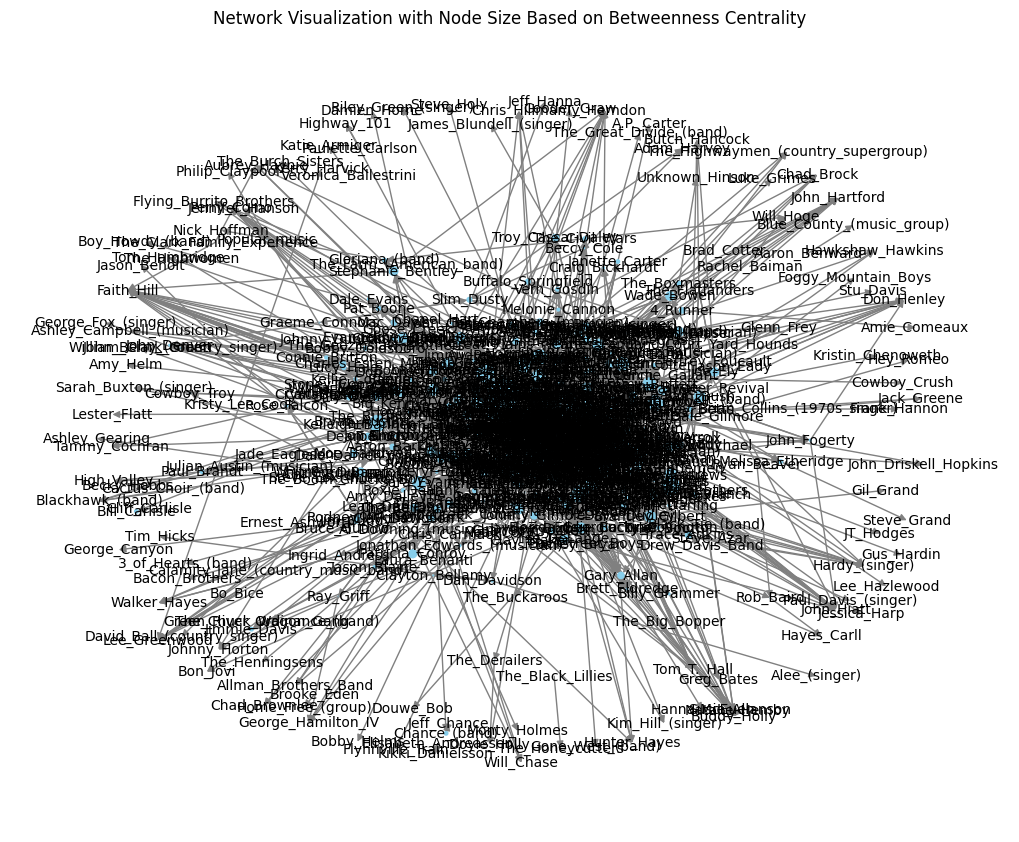

In [27]:
import matplotlib.pyplot as plt

# Get node sizes based on betweenness centrality (scaled)
node_size = [5000 * betweenness_centrality[node] for node in G.nodes()]

# Draw the graph with node sizes corresponding to betweenness centrality
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=node_size, node_color='skyblue', edge_color='gray', font_size=10)
plt.title('Network Visualization with Node Size Based on Betweenness Centrality')
plt.show()

Characters with high betweenness centrality act as bridges or key connectors between different groups or communities. They likely have an important role in ensuring the flow of information or relationships across the network. In the context of Wikipedia, these could be influential figures who are frequently linked between various subgenres or eras of country music.

3. Find the most central characters according to eigenvector centraility

In [18]:
# Calculate eigenvector centrality for the directed graph (both in- and out-edges)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

# Sort nodes by eigenvector centrality and get top 5
top_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nodes by eigenvector centrality:", top_eigenvector_centrality)

Top 5 nodes by eigenvector centrality: [('Vince_Gill', 0.358818180592061), ('Johnny_Cash', 0.34578943074602436), ('Emmylou_Harris', 0.2886726264402019), ('Sheryl_Crow', 0.2504538646828913), ('Bob_Dylan', 0.22120173158996792)]


Visualization with eigenvector centrality to define node size (Repeat Exercise 1):


C:\Users\jdiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\jdiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\drawing\nx_pylab.py:672: RuntimeWarning: invalid value encountered in sqrt
  return self.np.sqrt(marker_size) / 2


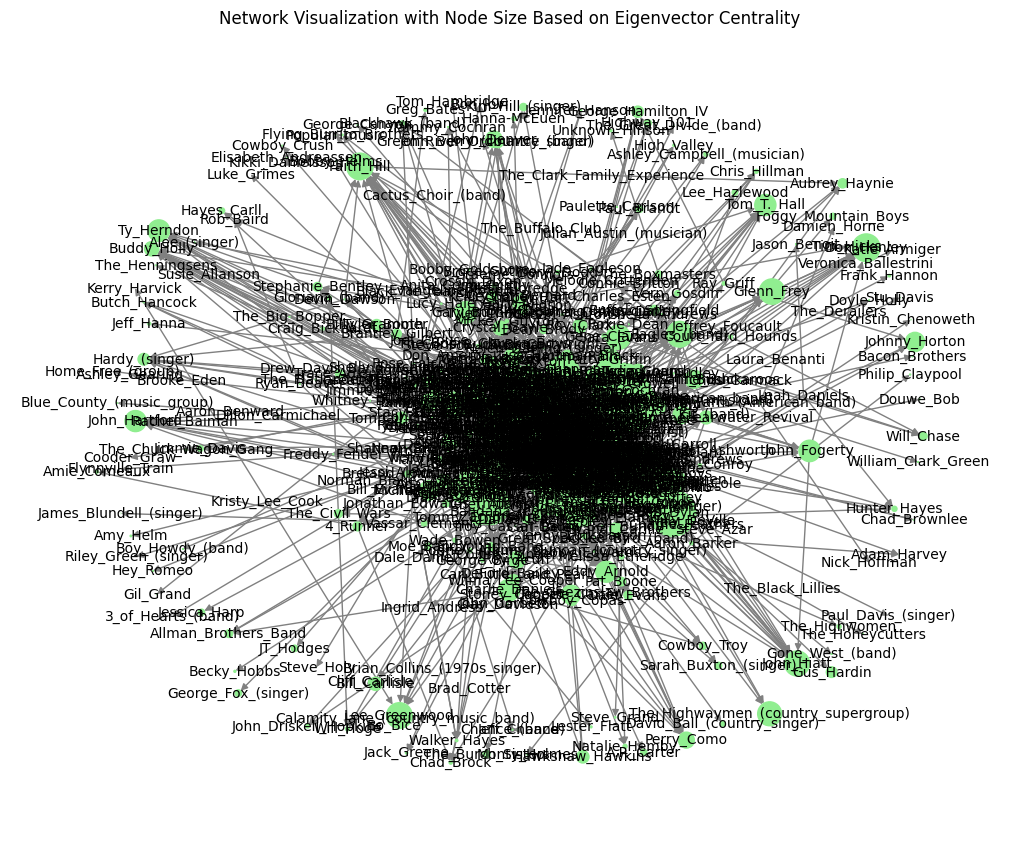

In [24]:
# Get node sizes based on eigenvector centrality (scaled)
node_size = [5000 * eigenvector_centrality[node] for node in G.nodes()]

# Draw the graph with node sizes corresponding to eigenvector centrality
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=node_size, node_color='lightgreen', edge_color='gray', font_size=10)
plt.title('Network Visualization with Node Size Based on Eigenvector Centrality')
plt.show()

Characters with high eigenvector centrality are important because they are well-connected to other well-connected nodes, indicating strong influence within the network. In contrast, betweenness centrality identifies nodes that play key roles as intermediaries between different parts of the network. The main difference lies in the focus of the measures: eigenvector centrality emphasizes a node’s connections to high-importance nodes, while betweenness focuses on bridging different groups.

4. Plot the betweenness centrality of nodes vs their degree centrality.

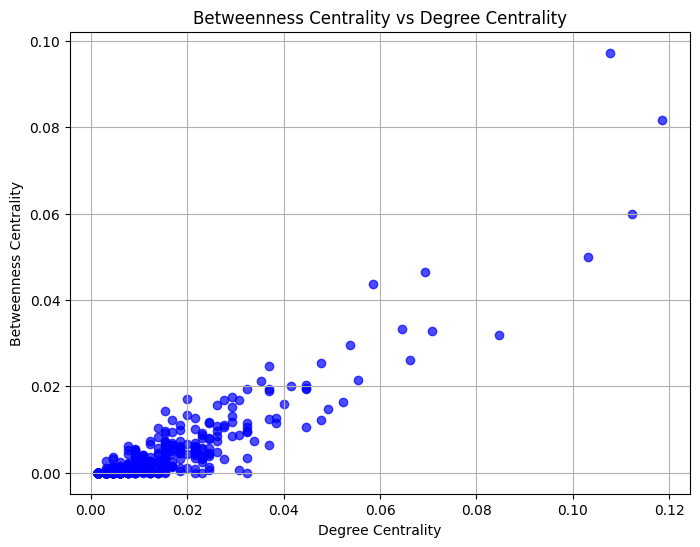

In [28]:
import numpy as np

# Prepare data for scatter plot
degree_centrality_values = np.array(list(degree_centrality.values()))
betweenness_centrality_values = np.array(list(betweenness_centrality.values()))

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(degree_centrality_values, betweenness_centrality_values, alpha=0.7, color='blue')
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.title('Betweenness Centrality vs Degree Centrality')
plt.grid(True)
plt.show()

Repeat with eigenvector centrality

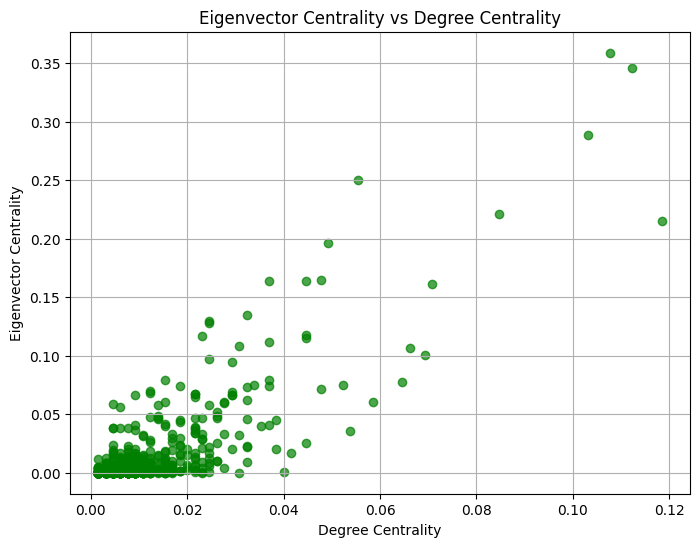

In [29]:
# Prepare data for scatter plot
eigenvector_centrality_values = np.array(list(eigenvector_centrality.values()))

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(degree_centrality_values, eigenvector_centrality_values, alpha=0.7, color='green')
plt.xlabel('Degree Centrality')
plt.ylabel('Eigenvector Centrality')
plt.title('Eigenvector Centrality vs Degree Centrality')
plt.grid(True)
plt.show()

5. Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.

In [30]:
# Convert to undirected graph
G_undirected = G.to_undirected()

# Check assortativity with respect to degree
degree_assortativity = nx.degree_assortativity_coefficient(G_undirected)
print("Degree Assortativity:", degree_assortativity)

Degree Assortativity: -0.0184784111247656


 A negative coefficient would indicate a disassortative network, where high-degree nodes tend to connect with low-degree nodes.
 
 6. Is the undirected version of the graph assortative with respect do the length_of_content nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and vice versa?.

In [31]:
# Assuming you have 'length_of_content' as a node attribute
# Check assortativity with respect to 'length_of_content'
content_assortativity = nx.attribute_assortativity_coefficient(G_undirected, 'length_of_content')
print("Content Assortativity:", content_assortativity)

Content Assortativity: nan


C:\Users\jdiaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


review 

7. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes  𝑁
  and probablity of connection  𝑝?
Take a look at the distribution of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.

In [34]:
# Get the largest connected component
largest_cc = max(nx.connected_components(G_undirected), key=len)
largest_subgraph = G_undirected.subgraph(largest_cc)

# Calculate the average shortest path length for the largest connected component
avg_shortest_path_length = nx.average_shortest_path_length(largest_subgraph)
print("Average Shortest Path Length for the Largest Connected Component:", avg_shortest_path_length)


Average Shortest Path Length for the Largest Connected Component: 3.7277739859594385


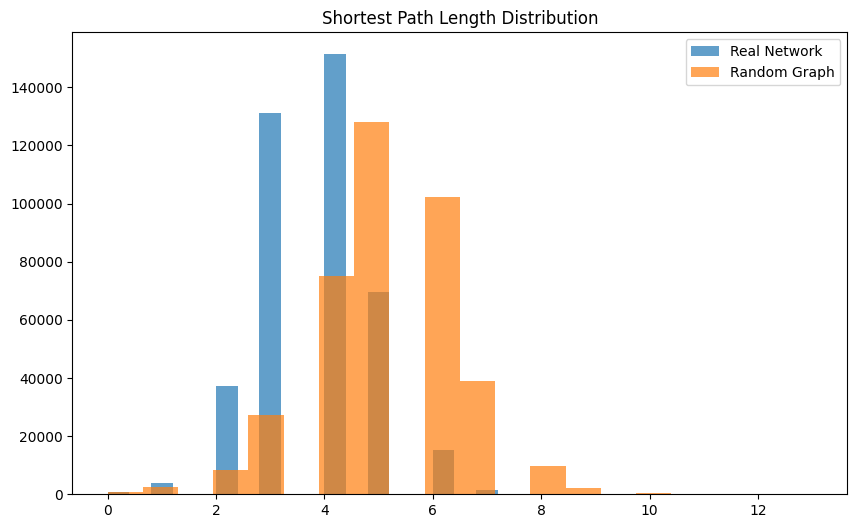

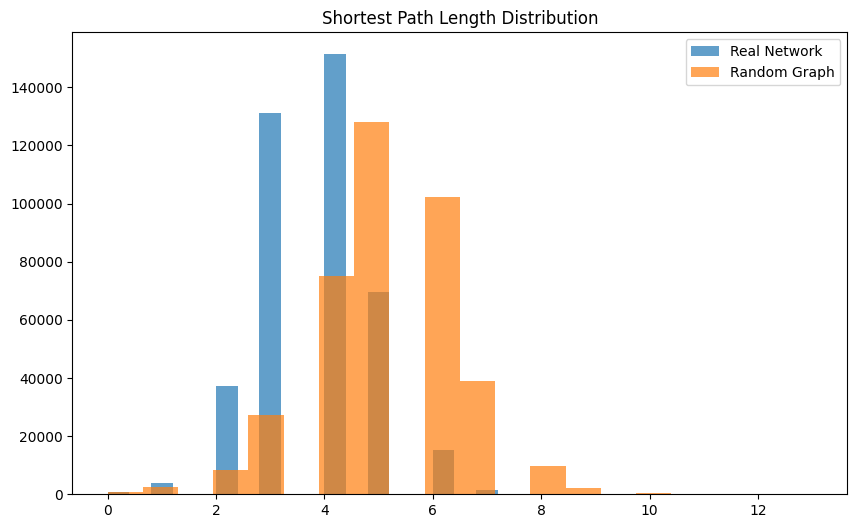

In [35]:
from networkx.generators.random_graphs import erdos_renyi_graph

# Generate a random graph with the same number of nodes and similar probability of connection
N = G.number_of_nodes()
p = nx.density(G)  # Connection probability
random_graph = erdos_renyi_graph(N, p)

# Calculate shortest path lengths for both graphs
sp_lengths_real = dict(nx.shortest_path_length(G_undirected))
sp_lengths_random = dict(nx.shortest_path_length(random_graph))

# Plot histograms of shortest path lengths
real_lengths = [sp_lengths_real[n][m] for n in sp_lengths_real for m in sp_lengths_real[n]]
random_lengths = [sp_lengths_random[n][m] for n in sp_lengths_random for m in sp_lengths_random[n]]

plt.figure(figsize=(10, 6))
plt.hist(real_lengths, bins=20, alpha=0.7, label='Real Network')
plt.hist(random_lengths, bins=20, alpha=0.7, label='Random Graph')
plt.legend()
plt.title('Shortest Path Length Distribution')
plt.show()


# Part C: Backbones and Network Visualization 

One method to clean up the "hairball"-looking networks, is known as the [backbone method](https://www.pnas.org/doi/10.1073/pnas.0808904106). Sometimes this method is also the "disparity filter". I explain what it's all about in the video below.

In [ ]:
YouTubeVideo("GOvsrVulbsg", width=800, height=450)

We only have one problem. As I explain in the video, the Backbone / Disparity Filter method *only works on weighted networks*. Our network does not have meaningful edge weights (since there's usually just a single link between two wiki pages), so as an experiment, we'll add weights proportional to the [edge betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html). The edge betweenness centrality is just like the node betweenness centrality that you know and love ... only that it's defined for edges instead of nodes.

Let's create two new weighted networks
 * **Weighted Network 1**: The ***undirected*** Country Music Network (Giant Connected Component) but with edge weights proportional to the edge betweenness centrality (let's renormalize so that the lowest weight is equal to 1 and the highest weight is equal to 100).
 * **Weighted Network 2**: The ***undirected*** Country Music Network  (Giant Connected Component) but with edge weights proportional to 1/(edge weight in Weighted Network 1).

Now we're ready for the exercise.


*Exercise 5*: Visualizing the Network Backbone

> 1. Extract the network backbone for both Weighted Network 1 and 2. You can implement it yourself based on the [scientific paper](https://www.pnas.org/doi/10.1073/pnas.0808904106) or find an implentation on GitHub (there are several ones to choose from ... I like [this implementation](https://www.michelecoscia.com/?page_id=287), which also includes other interesting edge filters). Figure out how your particular backbone extractor works (you may have to inspect the code itself, these packages are not always well documented). Play around with values of $\alpha$ to get an aestetically pleasing visualization (but don't make the resulting network too sparse).
> 2. Plot the resulting two networks using ForceAtlas2, still sizing nodes according to total degree. No need to color them. If your backbone has some disconnected nodes, feel free to not plot them. And remember to calculate a new layout to see how the structure has changed.
> 3. Comment on your results
>    * Do you see any structures in the networks now? Inspect some nodes to get a sense of what the structures captures in the two networks. Describe your findings in your own words.
>    * Weighted network 1 and 2 are very different. We have removed edges with low/high edge betweenness centrality respectively. What has that done to the networks? Describe what you see visually, and your explain your thoughts on what we've done to the network structure.

<div class="alert alert-block alert-info">
There's a lot to do today, so knock youself out with your LLM for this exercise, hopefully it can make your life easier (although I hope you'll do a bit of your own thinking, since a lot of complicated conceptual things are going on with the interplay between the backboning and edge betweenness and inverse edge betweenness!)</div>

One final thing. For now, the backbone is only for visualization. Especially because the edge weights are a bit artificial. Generally, it's not exactly clear what kind of information we get rid off when removing the non-backbone edges -- and in our case it's even less clear. Thus, we'll still do the exercises during the following weeks using the full network that preserves all of the connection information.


In [37]:
# Convert the directed graph to an undirected graph
G_undirected = G.to_undirected()

# Extract the largest connected component
largest_cc = max(nx.connected_components(G_undirected), key=len)
G_cc = G_undirected.subgraph(largest_cc).copy()


In [52]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Assume G_cc is the giant connected component of the undirected graph
# Calculate edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(G_cc)

# Normalize betweenness centrality between 1 and 100 for Weighted Network 1
min_betweenness = min(edge_betweenness.values())
max_betweenness = max(edge_betweenness.values())
edge_weights_1 = {edge: 1 + (99 * (bc - min_betweenness) / (max_betweenness - min_betweenness))
                  for edge, bc in edge_betweenness.items()}

# Create Weighted Network 1 with renormalized betweenness centrality as edge weights
G_weighted_1 = nx.Graph()
G_weighted_1.add_edges_from([(u, v, {'weight': w}) for (u, v), w in edge_weights_1.items()])

# Create Weighted Network 2 with inverse weights from Weighted Network 1
edge_weights_2 = {edge: 1 / weight for edge, weight in edge_weights_1.items()}
G_weighted_2 = nx.Graph()
G_weighted_2.add_edges_from([(u, v, {'weight': w}) for (u, v), w in edge_weights_2.items()])


In [50]:
import backboning